In [1]:
# TODO
# 1. Complete make_one_shot_task
# 2. Complete test one shot task
# 3. Complete plotting
# 4. See if using attention with some static probabilities help the detection of spoofing
# 5. Look at triple loss and computing it
# 6. CNN and attention to top of the book - https://towardsdatascience.com/self-attention-in-computer-vision-2782727021f6
    #Propose probabilities learnt through an LSTM network 
# 7. Higher prediction probabilities for top of book
    #https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
# 8. Fuck with data to get the desired result -b rebuild project
# 9. Clean up code, make fancy plots, write comments and so on
# 10. See if using LSTM to learn probabilities for attention would work 
# 11. Learn Families of classes for spoofing 
# 12. Custom loss function for family of identifications
# 13. Cross Modal for price and qty - https://iclr.cc/virtual/poster_B1lJzyStvS.html
# 14. Mutual information for either layering or other task - https://iclr.cc/virtual/poster_rkxoh24FPH.html, https://openreview.net/forum?id=rkxoh24FPH
# 15. Time seires with triplet leraning - https://papers.nips.cc/paper/8713-unsupervised-scalable-representation-learning-for-multivariate-time-series.pdf
# 16. Quadraple Learning - https://www.youtube.com/watch?v=_o2SLgjejAE
# 17. Add 13/14/15/16 for the work


##### RESULTS
1. No-Change Unnormalised Loss : 0.012634731829166412
2. Normalised Loss without anchor normalisation : 0.5267388820648193
3. Normalised Loss with anchor : 0.20129983127117157

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import tensorflow as tf
import time
from pylab import *
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage.util.shape import view_as_windows
from sklearn.metrics import roc_curve,roc_auc_score
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense, Conv2D, Layer, Lambda, Flatten
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

module_path = os.path.abspath(os.path.join('..'))
project_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)
if project_path not in sys.path:
    sys.path.append(project_path)
    
#print(device_lib.list_local_devices())

In [2]:
# Hyperparameters
nb_classes=2
cols, rows = 2, 30
input_shape = (cols, rows, 1)
volume_imbalace = 0.1
evaluate_every = 10000 # interval for evaluating on one-shot tasks
batch_size = 12
n_iter = 50000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
num_frames = 100

### Data Loading and Cleansing

In [3]:
#1. Draw Picture of your data like CRIMY
#2. Loop through all the data and create a set with data

In [5]:
spy_train = np.load(project_path + '/data/train/20160901/SPY_EDGX.npy')
goog_train = np.load(project_path + '/data/train/20160901/GOOG_EDGX.npy')
train_data = np.vstack((spy_train, goog_train))

goog_test = np.load(project_path + '/data/test/20160902/VOD_ARCA.npy')


model_path = project_path + '/weights/spoof'
model_cp_path = project_path + '/check_point/spoof'

In [7]:
def retrieve_cleansed_data(lob, width=num_frames):
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    quantile_transformer = QuantileTransformer()

    # As evidenced by above, we can technically select all in the second axis as there is only 1 element. However, 
    # because we need a 2d input we make it 0. The 3rd axis is side so we need this
    lob_qty_buy = pd.DataFrame(lob['quantity'][:,0,0,0:15])
    max_buy = np.amax(lob_qty_buy, axis=1)
    lob_qty_buy = lob_qty_buy.replace(0, np.NaN)
    avg_buy = lob_qty_buy.mean().mean()
    vol_sum_buy = lob_qty_buy.sum(axis=1)
    
    lob_qty_sell = pd.DataFrame(lob['quantity'][:,0,1,0:15])
    max_sell = np.amax(lob_qty_sell, axis=1)
    lob_qty_sell = lob_qty_sell.replace(0, np.NaN)
    avg_sell = lob_qty_sell.mean().mean()
    vol_sum_sell = lob_qty_sell.sum(axis=1)
    
    vol_imbalance = (vol_sum_buy - vol_sum_sell) / (vol_sum_buy + vol_sum_sell)
    
    label_df = pd.concat([vol_imbalance, pd.Series(lob['action'].ravel()), pd.Series(lob['side'].ravel()), 
                         max_buy, max_sell], axis=1)
    label_df[5] = label_df[0].diff() # Change in the values of the two states of OB (We take diff of prev row)
    label_df[6] = 0
  
    label_df[6] = np.where(((label_df[1] == 2) & (label_df[2] == 'B') & (np.abs(label_df[5]) > volume_imbalace) & 
                            (label_df[3] > avg_buy)), 1, 
                             np.where(((label_df[1] == 2) & (label_df[2] == 'S') & 
                                       (np.abs(label_df[5]) > volume_imbalace) &
                                       (label_df[4] > avg_sell)), 2, label_df[6].values))
    label_df = label_df.iloc[width-1:]
    Y_labels = label_df[6].reset_index(drop=True)
   
    # Normalise positive samples
    # these array manipulations are to get a final array where b-s in same array group
    lob_n, d, w, h = lob['quantity'].shape
    b_qty = lob['quantity'][:,0,0,:]
    s_qty = lob['quantity'][:,0,1,:]
    lob_qty = np.stack((b_qty, s_qty), axis=2)

    lob_qty = lob_qty.reshape(-1,1)
   # lob_qty = min_max_scaler.fit_transform(lob_qty)
    lob_qty = lob_qty.reshape(lob_n, h, w)
    
    b_price = lob['price'][:,0,0,:]
    s_price = lob['price'][:,0,1,:]
    lob_price = np.stack((b_price, s_price), axis=2)

    lob_price = lob_price.reshape(-1,1)
   # lob_price = quantile_transformer.fit_transform(lob_price)
    lob_price = lob_price.reshape(lob_n, h, w)


    lob_states = np.stack((lob_qty, lob_price), axis=-1)
    lob_states = lob_states.reshape(lob_n, h, w, 2)
    lob_states = view_as_windows(lob_states,(width,1,1,1))[...,0,0,0].transpose(0,4,1,2,3)
    
    print(lob_states.shape)
    print(Y_labels.shape)
    return lob_states, Y_labels

X_train, Y_train = retrieve_cleansed_data(train_data)
X_test, Y_test = retrieve_cleansed_data(goog_test)

(1940896, 100, 30, 2, 2)
(1940896,)
(502893, 100, 30, 2, 2)
(502893,)


### Model Initialisation

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

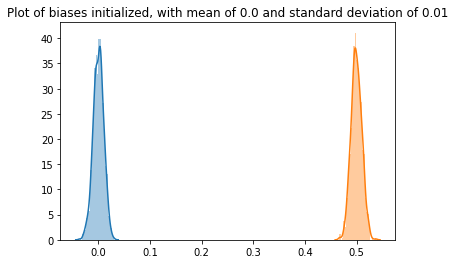

In [8]:
def initialize_weights(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [9]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs

        hardest_positive_dist = tf.reduce_max(tf.square(tf.subtract(anchor, positive)), axis=-1)
        tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

        # shape (batch_size)
        hardest_negative_dist = tf.reduce_min(tf.subtract(anchor, negative), axis=-1)
        tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))
    
        # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
        triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + self.alpha, 0.0)
        # Get final mean triplet loss
        triplet_loss = tf.reduce_mean(triplet_loss)
        return triplet_loss
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 30, 2, 2)]   0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 30, 2, 2)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 2, 32)         96        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 2, 64)         18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 2, 128)        8320      
_________________________________________________________________
lambda_3 (Lambda)            (None, 100, 7680)         0         
_________________________________________________________________
tcn_1 (TCN)                  (None, 100, 128)          3311

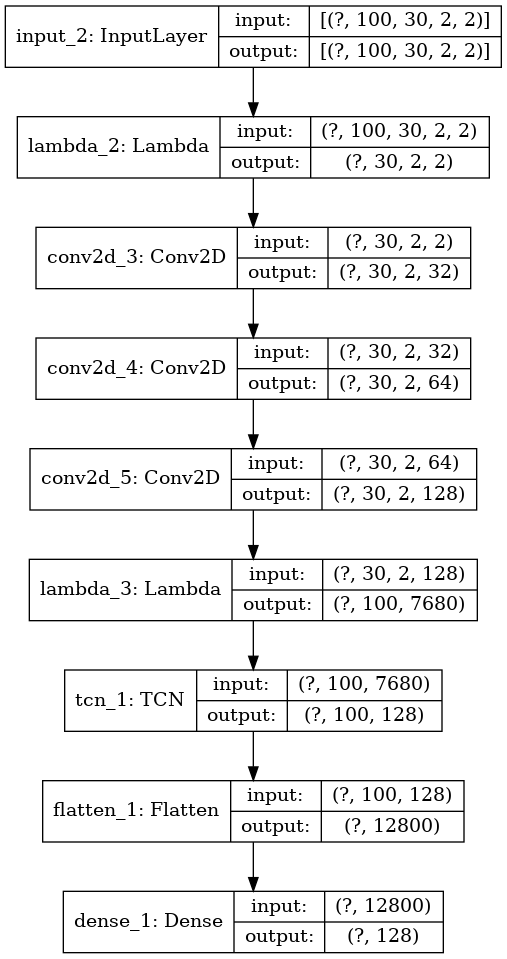

In [14]:
def embedding_model(frames, h, w, c, input_shape, dimensions, include_top=False, pooling=None, classes=1):  
    inp = Input(shape=(frames, h, w, c))
    out = Lambda(lambda y: K.reshape(y, (-1, h, w, c)))(inp)
    out = Conv2D(32, kernel_size=(1,1), activation='relu', strides=1, padding="same", input_shape=input_shape,
                   use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias)(out)
   # out = MaxPooling2D()(out)
    out = Conv2D(64, kernel_size=(3,3), activation='relu', strides=1, padding="same",
                   use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias)(out)
    out = Conv2D(128, kernel_size=(1,1), activation='relu', strides=1, padding="same",
                   use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias)(out)
    num_features_cnn = np.prod(K.int_shape(out)[1:])
    out = Lambda(lambda y: K.reshape(y, (-1, num_frames, num_features_cnn)))(out)
    out = TCN(nb_filters=128, return_sequences=True)(out)
    out = Flatten()(out)
    out = Dense(128, activation=None, kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform')(out)    
    return Model(inputs=inp, outputs=out)


def triplets_model(input_shape, embedding, include_top=False, pooling=None):

    anchor_input = Input(shape=input_shape, name='anchor_input')
    positive_input = Input(shape=input_shape, name='positive_input')
    negative_input = Input(shape=input_shape, name='negative_input')

    # Get the embedded values
    encoded_a = embedding(anchor_input)
    encoded_p = embedding(positive_input)
    encoded_n = embedding(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    triplet_net = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    return triplet_net

build_embedding = embedding_model(num_frames, 30, 2, 2, input_shape=(num_frames, 30, 2, 2), dimensions=60)
build_triplet = triplets_model(input_shape=(num_frames, 30, 2, 2), embedding=build_embedding)
optimizer = Adam(lr = 0.00006)
build_triplet.compile(loss=None,optimizer=optimizer)
build_embedding.summary()
build_triplet.summary()
print(build_triplet.metrics_names)
tcn_full_summary(build_embedding, expand_residual_blocks=False)
plot_model(build_embedding, 'multi_input_and_output_model.png', show_shapes=True)

### Training Triplet Net

In [11]:
def get_triplet_batch_spoof(batch_size, lob_states, labels):
    n_examples, t, h, w, d = lob_states.shape
    triplets = [np.zeros((batch_size, t, h, w, d)) for i in range(3)]
    labels_u = labels[labels==0]
    labels_b = labels[labels==1]
    labels_s = labels[labels==2]
    for i in range(batch_size):
        if (i%5==0):
            idx_a = labels_b.sample(1)
            idx_p = labels_b.sample(1)
            idx_n = labels_s.sample(1)
        elif (i%5==1):
            idx_a = labels_b.sample(1)
            idx_p = labels_b.sample(1)
            idx_n = labels_u.sample(1)
        elif (i%5==2):
            idx_a = labels_s.sample(1)
            idx_p = labels_s.sample(1)
            idx_n = labels_b.sample(1)
        elif (i%5==3):
            idx_a = labels_s.sample(1)
            idx_p = labels_s.sample(1)
            idx_n = labels_u.sample(1)
        elif (i%5==4):
            idx_a = labels_u.sample(1)
            idx_p = labels_u.sample(1)
            idx_n = labels_b.sample(1)
        else:
            idx_a = labels_u.sample(1)
            idx_p = labels_u.sample(1)
            idx_n = labels_s.sample(1)
   
        triplets[0][i,:,:,:,:] = lob_states[idx_a]
        triplets[1][i,:,:,:,:] = lob_states[idx_p]
        triplets[2][i,:,:,:,:] = lob_states[idx_n]
        
    return [triplets[0], triplets[1], triplets[2]]
    
#get_triplet_batch_spoof(2, X_train, Y_train)

def triplet_generator(batch_size, positive_samples, neg_train, anchor):
    while True:
        inputs, targets = get_triplet_batch(batch_size, positive_samples, neg_train, anchor)
        label = None
        yield ({'anchor_input': inputs[0], 'positive_input': inputs[1], 'negative_input': inputs[2]},\
               [targets[0], targets[1], targets[2]])

In [12]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))

def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m, num_frame, h, w, 1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m-1):
            #Against all other images
            for j in range(i+1,m-1):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
               # print(probs[k])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                   # print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no 
        instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes, num_frames, rows, cols, 2))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = X_test[i,:,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network, n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))

    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold)))
    # show the plot
    plt.show()

Starting training process!!
-------------------------------------
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

 ------------- 

[10000] Time for 10000 iterations: 295.0 mins, Train Loss: 0.16518285870552063
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


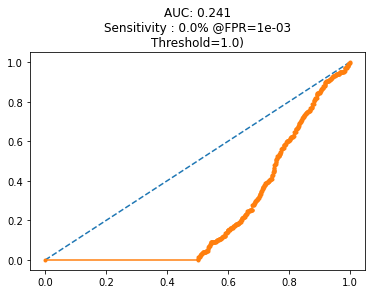

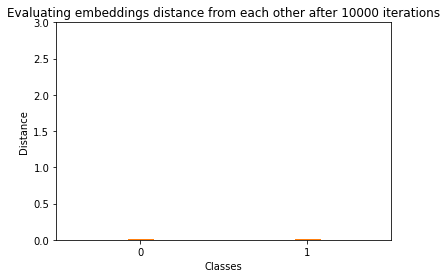


 ------------- 

[20000] Time for 20000 iterations: 596.5 mins, Train Loss: 0.1584460437297821


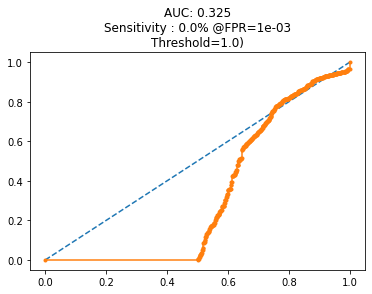

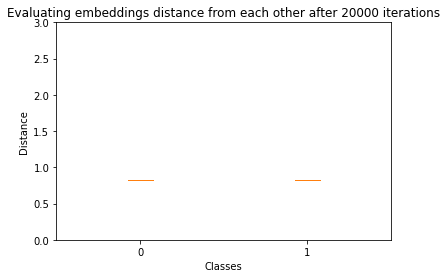


 ------------- 

[30000] Time for 30000 iterations: 805.5 mins, Train Loss: 0.15720346570014954


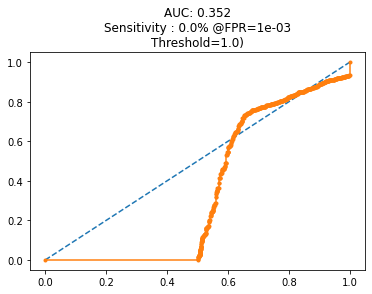

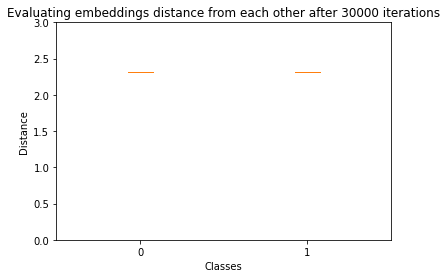


 ------------- 

[40000] Time for 40000 iterations: 1044.8 mins, Train Loss: 0.15657491981983185


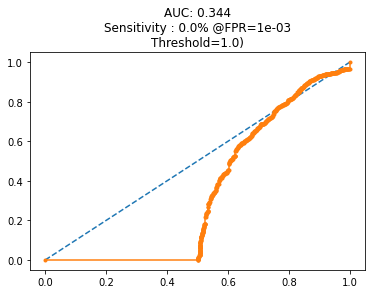

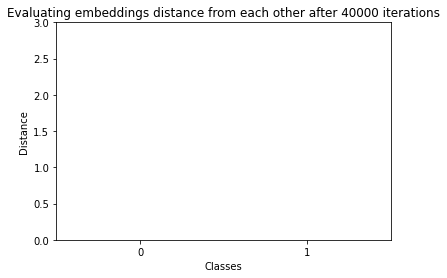


 ------------- 

[50000] Time for 50000 iterations: 1276.2 mins, Train Loss: 0.1564972996711731


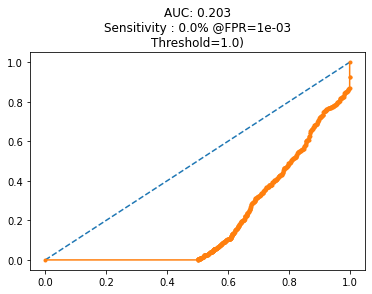

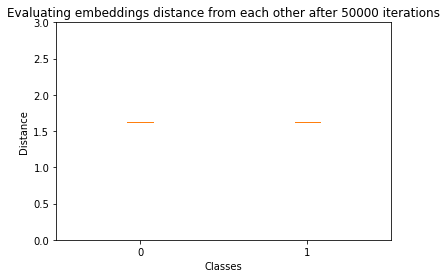

In [13]:
print("Starting training process!!")
print("-------------------------------------")
t_start = time.time()
n_iteration=0
#dummy_target = [np.zeros((batch_size,15)) for i in range(3)]
for i in range(1, n_iter+1):
    triplets = get_triplet_batch_spoof(batch_size, X_train, Y_train)
    loss = build_triplet.train_on_batch(triplets, None)
    n_iteration += 1
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}"\
              .format(i, (time.time()-t_start)/60.0,loss,n_iteration))
        probs, yprob = compute_probs(build_embedding, X_test[:n_val,:,:,:,:], Y_test[:n_val])
        fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
        draw_roc(fpr, tpr, thresholds)
        draw_interdist(build_embedding, n_iteration)
       # print("Probability " + str(probs))
       # print("YProbs " + str(yprob))
        #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
        #draw_roc(fpr, tpr)

### Validation / Evaluation

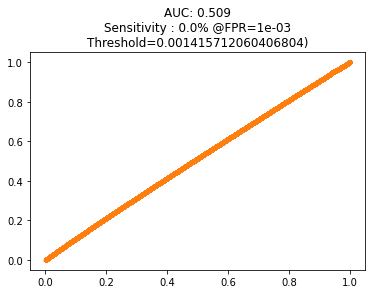

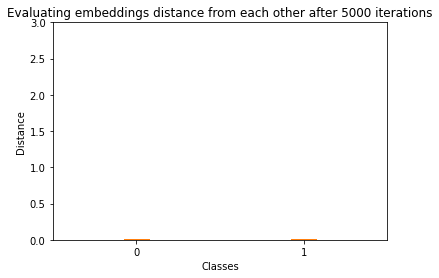

In [41]:
#Testing on an untrained network
probs, yprob = compute_probs(build_embedding ,X_train[:5000,:,:,:,:], Y_train[:5000])
fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding, n_iter)

In [ ]:
labels_b = Y_test[Y_test==1]
labels_s = Y_test[Y_test==2]
X_test[labels_s.index].shape
y = labels_s.reset_index(drop=True)

In [ ]:
#Testing on an untrained network
probs, yprob = compute_probs(build_embedding ,X_test[labels_s.index], y)
fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding, n_iter)

In [ ]:
#Testing on an untrained network
probs, yprob = compute_probs(build_embedding ,X_train[:2500,:,:,:,:], Y_train[:2500])
fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding, n_iter)

In [ ]:
from sklearn.metrics import roc_auc_score

def power_mean(x, p=-5):
    return np.power(np.mean(np.power(x, p)),1/p)

def get_s_auc(y_true,y_pred,y_identity):
    mask = y_identity==1
    s_auc = roc_auc_score(y_true[mask],y_pred[mask])
    return s_auc

def get_bpsn_auc(y_true,y_pred,y_identity):
    mask = (y_identity==1) & (y_true==0) | (y_identity==0) & (y_true==1)
    bpsn_auc = roc_auc_score(y_true[mask],y_pred[mask])
    return bpsn_auc

def get_bspn_auc(y_true,y_pred,y_identity):
    mask = (y_identity==1) & (y_true==1) | (y_identity==0) & (y_true==0)
    bspn_auc = roc_auc_score(y_true[mask],y_pred[mask])
    return bspn_auc

def get_total_auc(y_true,y_pred,y_identities):

    N = y_identities.shape[1]
    saucs = np.array([get_s_auc(y_true,y_pred,y_identities[:,i]) for i in range(N)])
    bpsns = np.array([get_bpsn_auc(y_true,y_pred,y_identities[:,i]) for i in range(N)])
    bspns = np.array([get_bspn_auc(y_true,y_pred,y_identities[:,i]) for i in range(N)])

    M_s_auc = power_mean(saucs)
    M_bpsns_auc = power_mean(bpsns)
    M_bspns_auc = power_mean(bspns)
    rauc = roc_auc_score(y_true,y_pred)


    total_auc = M_s_auc + M_bpsns_auc + M_bspns_auc + rauc
    total_auc/= 4

    return total_auc

In [ ]:
def DrawTestImage(network, images, refidx=500):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N=4
    _, w,h,c = list_of_test[0].shape
    nbimages=images.shape[0]
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((nb_classes,w,h,c))
    for i in range(nb_classes):
        ref_images[i,:,:,:1] = list_of_test[i][refidx,:,:,:1]
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        #Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,nb_classes+1,1)
        axis("off")
        plotidx = 2
            
        #Draw this image    
        #plt.imshow(images[i,:,:,0],vmin=0, vmax=1,cmap='Greys')
        plt.matshow(images[i,:,:,0], cmap='gray')
        #sns.heatmap(images[i,:,:,0], vmin=0, vmax=5000, cmap='Greens', center=None,
           #             robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
           #             cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels=True, 
           #             yticklabels=True, mask=None, ax=None)
        subplot.title.set_text("Test image")
            
        for ref in range(nb_classes):
            #Compute distance between this images and references
            dist = compute_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,nb_classes+1,plotidx)
            axis("off")
            #plt.imshow(ref_images[ref,:,:,0],vmin=0, vmax=1,cmap='Greys')
            plt.matshow(ref_images[ref,:,:,0], vmin=0, vmax=200000, cmap='gray')
            #sns.heatmap(ref_images[ref,:,:,0].reshape(2,30).T, vmin=0, vmax=5000, cmap='Greens', center=None,
             #           robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
              #          cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels=True, 
               #         yticklabels=True, mask=None, ax=None)
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1

In [ ]:
for i in range(2):
    DrawTestImage(build_embedding,np.expand_dims(list_of_train[i][230,:,:,:,:],axis=0))

In [ ]:
#Full evaluation
probs,yprob = compute_probs(build_embedding,X_test,Y_test)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(build_embedding,n_iteration)

In [ ]:
for i in range(2):
    DrawTestImage(build_embedding,np.expand_dims(list_of_train[i][680,:,:,:],axis=0))

In [ ]:
checkpoint = ModelCheckpoint(model_cp_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=2)
callbacks_list = [checkpoint, early]  # early

gen_tr = triplet_generator(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)

history = triplet_model.fit_generator(gen_tr, 
                              epochs=10, 
                              verbose=1, 
                              workers=4,
                              steps_per_epoch=200, 
                              validation_steps=20, use_multiprocessing=True)

In [ ]:
train_preds  = []
train_file_names = []
for i in range(1, n_iter+1):
    inputs, targets = data_generator(32, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1, 1)
    predicts = triplet_model.predict(inputs)
    print(predicts[0])
    predicts = predicts.tolist()
    train_preds += predicts
    targets = targets.tolist()
    train_file_names += targets
train_preds = np.array(train_preds)


test_preds  = []
test_file_names = []
for i in range(1, n_iter+1):
    inputs, targets = data_generator(32, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1, 1)
    if i % evaluate_every == 0:
        predicts = embedding_model.predict(inputs)
        predicts = predicts.tolist()
        test_preds += predicts
        targets = targets.tolist()
        test_file_names += targets
test_preds = np.array(test_preds)


In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(train_preds)

In [ ]:
distances_test, neighbors_test = neigh.kneighbors(test_preds)
distances_test, neighbors_test = distances_test.tolist(), neighbors_test.tolist()

In [ ]:
gen_te = triplet_generator_new(batch_size, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)
predictions = triplet_model.embedding_model.predict(gen_te, steps=1)
print(predictions)

In [ ]:
# plt.legend()
# plt.show()
def eva_plot(History, epoch):
    plt.figure(figsize=(20,10))
#     sns.lineplot(range(1, epoch+1), History.history['acc'], label='Train Accuracy')
#     sns.lineplot(range(1, epoch+1), History.history['val_acc'], label='Test Accuracy')
#     plt.legend(['train', 'validaiton'], loc='upper left')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.show()
    plt.figure(figsize=(20,10))
    sns.lineplot(range(1, epoch+1), History.history['loss'], label='Train loss')
    sns.lineplot(range(1, epoch+1), History.history['val_loss'], label='Test loss')
    plt.legend(['train', 'validaiton'], loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Loss Graph")
    plt.show()
    
eva_plot(history, 4)

def val_plot(History, epoch):
    plt.figure(figsize=(20,10))
#     sns.lineplot(range(1, epoch+1), History.history['acc'], label='Train Accuracy')
#     sns.lineplot(range(1, epoch+1), History.history['val_acc'], label='Test Accuracy')
#     plt.legend(['train', 'validaiton'], loc='upper left')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.show()
    plt.figure(figsize=(20,10))
    sns.lineplot(range(1, epoch+1), History.history['model_8_loss'], label='Embedding Train loss')
    sns.lineplot(range(1, epoch+1), History.history['val_model_8_loss'], label='Embedding Test loss')
    plt.legend(['train', 'validaiton'], loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Loss Graph")
    plt.show()
    
val_plot(history, 4) 

In [ ]:
def triplet_loss1(y_true, y_pred, alpha=0.4):
    print("for distance branch, y_pred.shape:  ", y_pred)       # [Batch_dim, vec_dim*3]

    vec_len = y_pred.shape.as_list()[-1]

    anchor = y_pred[:, :int(vec_len/3)]
    positve = y_pred[:, int(vec_len/3):int(vec_len*2/3)]
    negative = y_pred[:, int(vec_len*2/3):]

    pos_dist = K.sum(K.square(anchor - positve), axis=1)
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    loss = K.maximum(0., pos_dist - neg_dist + alpha)

    return loss
a = tf.compat.v1.random_normal([5, 60], mean=6, stddev=0.1, seed = 1)

with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    y_true = (None, None, None)
    a = tf.compat.v1.random_normal([5, 60], mean=6, stddev=0.1, seed = 1)
    print(a)
    p = tf.compat.v1.random_normal([5, 60], mean=1, stddev=1, seed = 1)
    n = tf.compat.v1.random_normal([5, 60], mean=3, stddev=4, seed = 1)
    merged = concatenate([a, p, n], axis=-1)
    y_pred = (tf.compat.v1.random_normal([3, 60], mean=6, stddev=0.1, seed = 1),
              tf.compat.v1.random_normal([3, 60], mean=1, stddev=1, seed = 1),
              tf.compat.v1.random_normal([3, 60], mean=3, stddev=4, seed = 1), 
              tf.compat.v1.random_normal([3, 60], mean=3, stddev=4, seed = 1))
    loss = triplet_loss1(y_true, merged)
    
    print("loss = " + str(loss.eval()))


In [ ]:
evaluate_every = 20 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 2
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs, targets) = get_triplet_batch(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
    #(inp, tar) = triplet_generator()
    loss = triplet_model.model.train_on_batch(inputs, targets)
    print(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)

  
        triplet_model.model.save_weights(os.path.join(model_path, 'weights_triplet.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

In [ ]:
import tensorflow as tf
import numpy as np

data = [[1,2,3],[4,5,6]]
data_np = np.asarray(data, np.float32)

data_tf = tf.convert_to_tensor(data_np, np.float32)

data_np.shape

In [ ]:
train_generator = triplet_generator(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
val_generator = triplet_generator(batch_size, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)

model.fit(generator=train_generator, steps_per_epoch=20, epochs=100,
                        validation_data=val_generator,
                        validation_steps=10,
                        verbose=1) #callbacks=[checkpoint])

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs, targets) = get_triplet_batch(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
    #(inp, tar) = triplet_generator()
    loss = triplet_model.model.train_on_batch(inputs, targets)
    print(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
      #  val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        triplet_model.model.save_weights(os.path.join(model_path, 'weights_triplet.{}.h5'.format(i)))
       # if val_acc >= best:
        #    print("Current best: {0}, previous best: {1}".format(val_acc, best))
         #   best = val_acc

### Training 

In [ ]:
class Training_Pipeline(object):
    def __init__(self):
        self._birthdate = time.time()
        
    @staticmethod
    def get_batch(batch_size, positive_samples, negative_samples, anchor):
        """Create batch of n pairs, half same class, half different class"""
        n_examples_p, d, w, h = positive_samples.shape
        n_examples_n = negative_samples.shape[0]

        # initialize 2 empty arrays for the input image batch
        pairs = [np.zeros((batch_size, w, h, 1)) for i in range(2)]

        # initialize vector for the targets
        targets=np.zeros((batch_size,))

        # make one half of it '1's, so 2nd half of batch has same class
        targets[batch_size//2:] = 1

        for i in range(batch_size):
            idx_p = rng.randint(0, n_examples_p)
            idx_n = rng.randint(0, n_examples_n)
            pairs[0][i,:,:,:] = anchor.reshape(w, h, 1)

            if i >= batch_size // 2:
                pairs[1][i,:,:,:] = positive_samples[idx_p].reshape(w, h, 1)
            else:
                pairs[1][i,:,:,:] = negative_samples[idx_n].reshape(w, h, 1)
        return pairs, targets
    
    def make_oneshot_task(self, N, positive_samples, negative_samples, anchor):
        """Create pairs of test image, support set for testing N way one-shot learning. """

        n_examples_p, d, w, h = positive_samples.shape
        n_examples_n = negative_samples.shape[0]

        test_lob = np.asarray([anchor]*N).reshape(N, w, h, 1)

       # print(test_lob)

        p_index = rng.randint(0, n_examples_p, size=(1,))
        n_index = rng.randint(0, n_examples_n, size=(N,))

        support_set = negative_samples[n_index]
       # print('n_index' + str(n_index))
      #  print(support_set[0])
      #  print(support_set[1])
        support_set[0] = positive_samples[p_index]
       # print('zero now')
       # print(support_set[0])
       # print('one now')
      #  print(support_set[1])
        support_set = support_set.reshape(N, w, h, 1)

        targets = np.zeros((N,))
        targets[0] = 1     
       # print(targets)
        targets, test_lob, support_set = shuffle(targets, test_lob, support_set)
        pairs = [test_lob, support_set]
        return pairs, targets

    def test_oneshot(self, model, N, k, s = "val", verbose = 0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        inputs = []
        targets = []
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            if s == 'train':
                inputs, targets = self.make_oneshot_task(N, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
            else:
                inputs, targets = self.make_oneshot_task(N, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)
            probs = model.predict(inputs)
            #print(probs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0 * n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    
    def generate(batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = get_batch(batch_size,s)
            yield (pairs, targets)

training_pipeline = Training_Pipeline()

In [ ]:
# Example of concat image visualization
np.set_printoptions(suppress=True)
pairs, targets = training_pipeline.make_oneshot_task(15, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
plot_oneshot_task(pairs, targets, 15)
print(targets)

### Plotting LOBs

In [ ]:
def plot_oneshot_task(pairs, targets, N): 
    '''
    Only prints out one before last element of a 
    '''
    count = 0
    fig, ax = plt.subplots(2, int(N/2), sharex='col', sharey='row', figsize=(15,15))
    lob_matrix = []
    lob_matrix.append(pairs[0][0])
    for j in range(0,int(N)):
        lob_matrix.append(pairs[1][j])
     
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    
    for i in range(0,2):
        for j in range(0,int(N/2)):
            sns.heatmap(lob_matrix[count][:,:,0].reshape(2,30).T, vmin=0, vmax=50000, cmap='Greens', center=None,
                        robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
                        cbar=True, cbar_kws=None, cbar_ax=cbar_ax, square=False, xticklabels=True, 
                        yticklabels=True, mask=None, ax=ax[i, j])
            count = count + 1
            print(lob_matrix[count][:,:,0])
    plt.show()

In [ ]:
def plot_oneshot_task(pairs, N):
    if N/2 == 1:
        end = int(N/2)
    else:
        end = int(N/2)
    fig, ax = plt.subplots(2, end, sharex='col', sharey='row', figsize=(15,15))
   # im = ax[0, 0].matshow(pairs[0][0].reshape(2,30).T)
   # print(pairs[0][1])
   # print(pairs[1][0])
   # print(pairs[0][0].shape)
    data_array = []
    data_array.append(pairs[0][0])
    #print(data_array[0][:,:,0])
    for j in range(0,int(N)):
        data_array.append(pairs[1][j])
    #print(np.moveaxis(data_array, -1, 0).shape)
   # print(data_array[0])
    count = 0
    initial_pair = 0
    for i in range(0,2):
        for j in range(0,int(N/2)):
            sns.heatmap(data_array[count][:,:,0].reshape(2,30).T, vmin=None, vmax=None, cmap=None, center=None,
                robust=False, annot=None, fmt='.2g', annot_kws=None, 
                linewidths=0, linecolor='white', cbar=True, cbar_kws=None, 
                cbar_ax=None, square=False, xticklabels='auto',
                yticklabels='auto', mask=None, ax=ax[i, j], **kwargs)
           # im = ax[i, j].matshow(data_array[count][:,:,0].reshape(2,30).T, cmap='BuPu')
            print(i)
            print(j)
            ax[i, j].text(0.5, 0.5, str((i, j)), fontsize=18, ha='right')
            count = count + 1
            initial_pair = 1
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    print(im)
    fig.colorbar(im, cax=cbar_ax)
    plt.show()


In [ ]:
def plot_oneshot_task(pairs, N):
    if N/2 == 1:
        end = int(N/2)
    else:
        end = int(N/2)
    fig, ax = plt.subplots(2, end, sharex='col', sharey='row', figsize=(15,15))
   # im = ax[0, 0].matshow(pairs[0][0].reshape(2,30).T)
   # print(pairs[0][1])
   # print(pairs[1][0])
    data_array = pairs[0][0]
    for j in range(0,int(N)):
        data_array = np.append(data_array, pairs[1][j], axis=-1)
    print(data_array)
    print(data_array.shape)
    print(np.moveaxis(data_array, -1, 0).shape)
    count = 0
    initial_pair = 0
    for i in range(0,2):
        for j in range(0,int(end)):
            im = ax[i, j].matshow(pairs[initial_pair][count].reshape(2,30).T, cmap='BuPu')
            ax[i, j].text(0.5, 0.5, str((i, j)), fontsize=18, ha='right')
            count = count + 1
            initial_pair = 1
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    print(im)
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
#(j-start)*(i+1)

In [ ]:
def plot_oneshot_task(pairs, N):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=N, figsize=(15,15))
    ax1.matshow(pairs[0][0].reshape(30,2), cmap='gray')
    img = concat_images(pairs[1], N)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Hyper parameters
#evaluate_every = 2 # interval for evaluating on one-shot tasks
#batch_size = 32
#n_iter = 20 # No. of training iterations
#N_way = 4 # how many classes for testing one-shot tasks
#n_val = 10 # how many one-shot tasks to validate on
#best = -1
#np.set_printoptions(suppress=True)

evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1

In [ ]:
model.metrics_names

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    inputs, targets = training_pipeline.get_batch(batch_size, pos_train, neg_train,\
                                                     spoof_ground_truth.spoof_step1_truth1)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = training_pipeline.test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

### Testing

In [ ]:
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

#### Baseline model based on nearest neighbors using euclidean distance

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [ ]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = training_pipeline.make_oneshot_task(N_ways,pos_val, neg_val,\
                                                            spoof_ground_truth.spoof_step1_truth1)
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [ ]:
ways = np.arange(1,15,2)
resume =  False
trials = 50

In [ ]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(training_pipeline.test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(training_pipeline.test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("-------------------------------------------------------------------------------------------------------")

In [ ]:
#Save accuracies on disk
with open(os.path.join(project_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)
    
#Load accuraces from disk
with open(os.path.join(project_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [ ]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*h,n*w))
    x = 0
    y = 0
    for example in range(nc):
        img[x*h:(x+1)*h,y*w:(y+1)*w] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [ ]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
    ax1.matshow(pairs[0][0].reshape(30,2), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Example of concat image visualization
pairs, targets = training_pipeline.make_oneshot_task(1,pos_train,neg_train,spoof_ground_truth.spoof_step1_truth1)
plot_oneshot_task(pairs)

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

In [ ]:
import tensorflow_datasets as tfds

def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

# Train the network
history = model.fit(
    train_dataset,
    epochs=5)

# Evaluate the network
results = model.predict(test_dataset)

# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()



from google.colab import files
files.download('vecs.tsv')
files.download('meta.tsv')
  

In [ ]:
# Reasons for Choices
Normalisation - https://stats.stackexchange.com/questions/7757/data-normalization-and-standardization-in-neural-networks
https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029
https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d
https://www.jeremyjordan.me/batch-normalization/